In [5]:
# Install (run only if not installed)
# !pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

plt.rcParams["figure.figsize"] = (9, 5)
plt.style.use('seaborn-v0_8-whitegrid')

In [7]:
# Replace with your CSV file path
# Example: "C:/Users/YourName/Downloads/Stock_Prices.csv"
df = pd.read_csv("ADANIPORTS.csv")

# Display basic info
print("Dataset loaded successfully!")
print(df.head())
print("\nColumns:", df.columns.tolist())

Dataset loaded successfully!
         Date      Symbol Series  Prev Close    Open     High    Low   Last  \
0  2007-11-27  MUNDRAPORT     EQ      440.00  770.00  1050.00  770.0  959.0   
1  2007-11-28  MUNDRAPORT     EQ      962.90  984.00   990.00  874.0  885.0   
2  2007-11-29  MUNDRAPORT     EQ      893.90  909.00   914.75  841.0  887.0   
3  2007-11-30  MUNDRAPORT     EQ      884.20  890.00   958.00  890.0  929.0   
4  2007-12-03  MUNDRAPORT     EQ      921.55  939.75   995.00  922.0  980.0   

    Close    VWAP    Volume      Turnover  Trades  Deliverable Volume  \
0  962.90  984.72  27294366  2.687719e+15     NaN             9859619   
1  893.90  941.38   4581338  4.312765e+14     NaN             1453278   
2  884.20  888.09   5124121  4.550658e+14     NaN             1069678   
3  921.55  929.17   4609762  4.283257e+14     NaN             1260913   
4  969.30  965.65   2977470  2.875200e+14     NaN              816123   

   %Deliverble  
0       0.3612  
1       0.3172  
2     

In [9]:
# Clean column names
df.columns = df.columns.str.strip()

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Sort by date and set as index
df = df.sort_values('Date').set_index('Date')

# Handle missing values by interpolation
df = df.interpolate()

# Display dataset info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3322 entries, 2007-11-27 to 2021-04-30
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              3322 non-null   object 
 1   Series              3322 non-null   object 
 2   Prev Close          3322 non-null   float64
 3   Open                3322 non-null   float64
 4   High                3322 non-null   float64
 5   Low                 3322 non-null   float64
 6   Last                3322 non-null   float64
 7   Close               3322 non-null   float64
 8   VWAP                3322 non-null   float64
 9   Volume              3322 non-null   int64  
 10  Turnover            3322 non-null   float64
 11  Trades              2456 non-null   float64
 12  Deliverable Volume  3322 non-null   int64  
 13  %Deliverble         3322 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 389.3+ KB
None


C:\Users\Jayesh\AppData\Local\Temp\ipykernel_21328\3206281943.py:11: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()


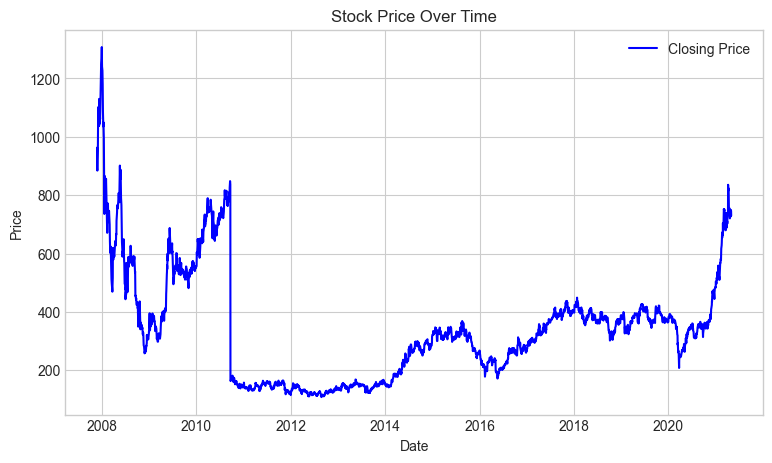

In [11]:
plt.figure()
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


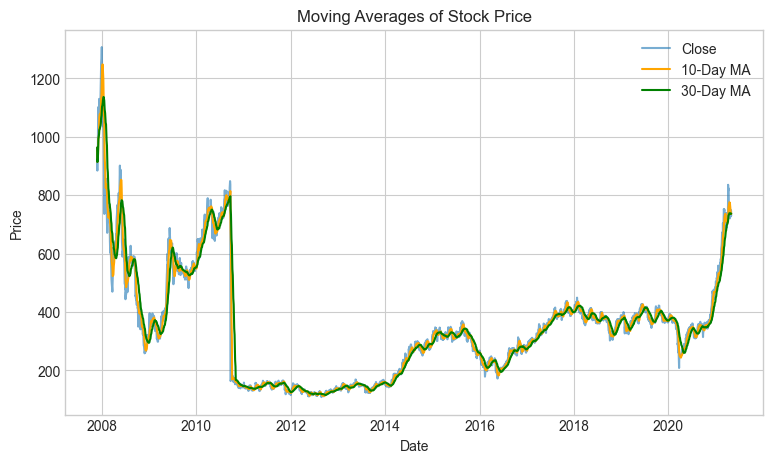

In [13]:
df['MA10'] = df['Close'].rolling(window=10, min_periods=1).mean()
df['MA30'] = df['Close'].rolling(window=30, min_periods=1).mean()

plt.figure()
plt.plot(df['Close'], label='Close', alpha=0.6)
plt.plot(df['MA10'], label='10-Day MA', color='orange')
plt.plot(df['MA30'], label='30-Day MA', color='green')
plt.title("Moving Averages of Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


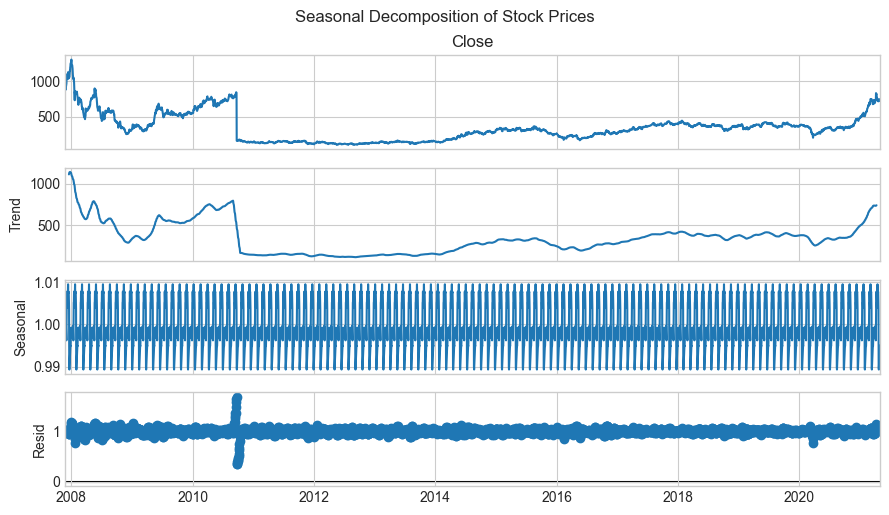

In [15]:
# Convert to business-day frequency and fill missing days
price_daily = df['Close'].asfreq('B').ffill()

# Decompose into trend, seasonal, and residual
decomp = seasonal_decompose(price_daily, model='multiplicative', period=30)
decomp.plot()
plt.suptitle("Seasonal Decomposition of Stock Prices", y=1.02)
plt.show()


In [17]:
if 'Volume' in df.columns:
    df['Return'] = df['Close'].pct_change()
    corr = df[['Return', 'Volume']].corr().iloc[0,1]
    print(f"Correlation between daily returns and volume: {corr:.3f}")
else:
    print("Volume column not found — skipping correlation analysis.")


Correlation between daily returns and volume: 0.091


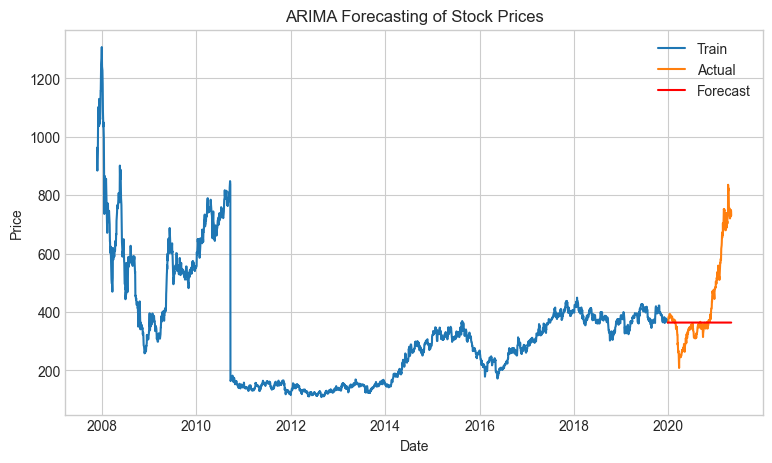

RMSE (Root Mean Squared Error): 159.86


In [19]:
# Convert to daily frequency for ARIMA
series = df['Close'].asfreq('B').ffill()

# Split into train/test (90/10 split)
train_size = int(len(series) * 0.9)
train, test = series.iloc[:train_size], series.iloc[train_size:]

# Build and fit ARIMA model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot forecast
plt.figure()
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title("ARIMA Forecasting of Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Evaluate forecast
rmse = math.sqrt(np.mean((forecast - test)**2))
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
